# Building Recommender Systems with Spotify Data

Most of us these days use Spotify or other music apps to listen to our favourite music. Have you ever wondered on what basis is the application making recommendations to you? We will build a recommendation system based on the data from Spotify. This is a working model of how recommendation works when you use the application as a guest user. 

## Import Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import requests
import seaborn as sns
plt.rcParams.update({'font.size': 22})
%matplotlib inline
import plotly.express as px


## Reading the Data

In [16]:
# download the file contents in binary format
r = requests.get('https://github.com/lauvshree/datasets/blob/main/spotify.csv.zip?raw=true')

with open("spotify.csv.zip", "wb") as code:
  code.write(r.content)

zf = zipfile.ZipFile("spotify.csv.zip") 

# # now read your csv file 
spotify_data = pd.read_csv(zf.open('spotify.csv'))



In [17]:
spotify_data.head(10)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.5170,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.7980,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.7070,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
5,0.996000,['Mamie Smith & Her Jazz Hounds'],0.424,198627,0.2450,0,3HnrHGLE9u2MjHtdobfWl9,0.799000,5,0.2350,-11.470,1,Crazy Blues - 78rpm Version,9,1920,0.0397,103.870,0.4770,1920
6,0.992000,['Mamie Smith'],0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.1760,-12.453,1,Don't You Advertise Your Man,5,1920,0.0592,85.652,0.4870,1920
7,0.996000,['Mamie Smith & Her Jazz Hounds'],0.474,186173,0.2390,0,02FzJbHtqElixxCmrpSCUa,0.186000,9,0.1950,-9.712,1,Arkansas Blues,0,1920,0.0289,78.784,0.3660,1920
8,0.996000,['Francisco Canaro'],0.469,146840,0.2380,0,02i59gYdjlhBmbbWhf8YuK,0.960000,8,0.1490,-18.717,1,La Chacarera - Remasterizado,0,1920-07-08,0.0741,130.060,0.6210,1920
9,0.006820,['Meetya'],0.571,476304,0.7530,0,06NUxS2XL3efRh0bloxkHm,0.873000,8,0.0920,-6.943,1,Broken Puppet - Original Mix,0,1920-01-01,0.0446,126.993,0.1190,1920


In [18]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

## Exploratory Data Analysis

### Plot the data according the popularity rating

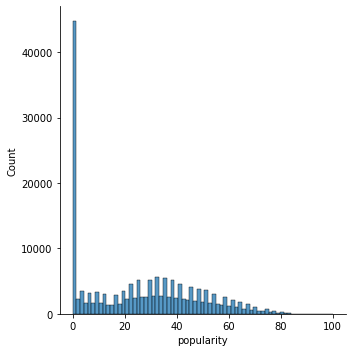

In [19]:
sns.displot(spotify_data['popularity'])

### Music Over Time

Visualize the songs over a period of time. We will observe the number of songs in each decade.

In [20]:
def get_decade(year):
    
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    
    return decade

spotify_data['decade'] = spotify_data['year'].apply(get_decade)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



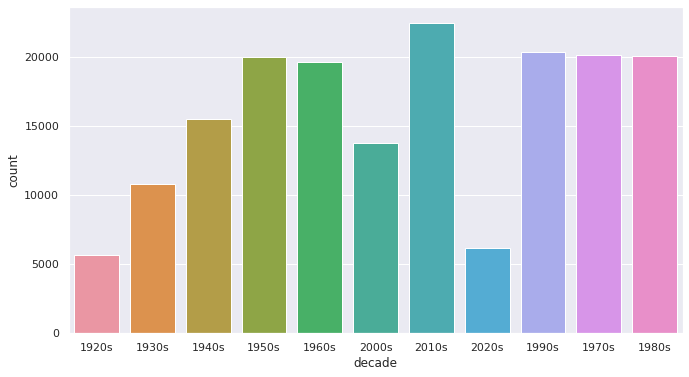

In [21]:
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(spotify_data['decade'])

### Getting the most popular songs

Return the first 10 rows ordered by column `popularity` in descending order.

In [ ]:
top10_genres = spotify_data.nlargest(10, 'popularity')
top10_genres

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,decade
20062,0.7210,['Olivia Rodrigo'],0.585,242014,0.436,1,7lPN2DXiMsVn7XUKtOW1CS,0.000013,10,0.1050,-8.761,1,drivers license,100,2021-01-08,0.0601,143.874,0.132,2021,2020s
19862,0.2210,"['24kGoldn', 'iann dior']",0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,7,0.2720,-3.558,0,Mood (feat. iann dior),96,2020-07-24,0.0369,90.989,0.756,2020,2020s
19866,0.4680,['Ariana Grande'],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,0,0.0931,-4.771,1,positions,96,2020-10-30,0.0878,144.015,0.682,2020,2020s
19886,0.4010,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,DÁKITI,95,2020-10-30,0.0544,109.928,0.145,2020,2020s
19976,0.2120,['KAROL G'],0.863,178947,0.666,1,7vrJn5hDSXRmdXoR30KgF1,0.000493,1,0.1030,-4.158,0,BICHOTA,95,2020-10-23,0.1520,163.908,0.838,2020,2020s
19868,0.2370,['Ariana Grande'],0.830,173711,0.585,1,6Im9k8u9iIzKMrmV7BWtlF,0.000000,0,0.2480,-6.476,1,34+35,94,2020-10-30,0.0940,109.978,0.485,2020,2020s
19870,0.1900,['CJ'],0.711,123429,0.598,1,5vGLcdRuSbUhD8ScwsGSdA,0.000000,3,0.1500,-7.621,0,Whoopty,94,2020-08-20,0.1820,140.175,0.737,2020,2020s
19872,0.2130,['The Kid LAROI'],0.662,161385,0.413,1,27OeeYzk6klgBh83TSvGMA,0.000000,0,0.1340,-7.357,1,WITHOUT YOU,94,2020-11-06,0.0299,93.005,0.467,2020,2020s
19876,0.2180,['Billie Eilish'],0.889,174321,0.340,0,54bFM56PmE4YLRnqpW6Tha,0.130000,11,0.0550,-7.773,0,Therefore I Am,94,2020-11-12,0.0697,94.009,0.716,2020,2020s
19928,0.0303,"['Bad Bunny', 'ROSALÍA']",0.856,203201,0.618,0,2XIc1pqjXV3Cr2BQUGNBck,0.000000,7,0.0866,-4.892,1,LA NOCHE DE ANOCHE,94,2020-11-27,0.2860,81.993,0.391,2020,2020s


We will only consider the numeric data for clustering. Scale the features of **numeric** data type and cluster them.

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_dtypes = spotify_data.select_dtypes(np.number)
num_dtypes.drop(['year'], axis=1,inplace=True)
scaled_df = scaler.fit_transform(num_dtypes)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
kmclustering = KMeans(n_clusters=10, random_state=25)
kmclustering.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=25, tol=0.0001, verbose=0)

### Calculating Inertia - 

Inertia is a measure of how well a dataset has been clustered by K-Means. 

A good model is one with low inertia and a low number of clusters. 

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion.




This cell below takes about 50 mins to 1 hour to run. The purpose of this is to determine, the ideal number of clusters.

In [25]:
wss =[] 
for i in range(1,51):
    kmclustering = KMeans(n_clusters=i, random_state=25)
    kmclustering.fit(scaled_df)
    wss.append(kmclustering.inertia_)



### Elbow curve
Let's plot the inertia for different cluster sizes, to see the ideal number of clusters we should choose.

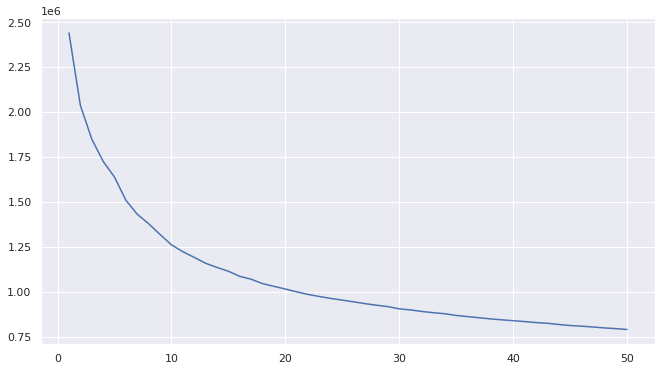

In [26]:
plt.plot(range(1,51), wss)

In [27]:
kmclustering = KMeans(n_clusters=20, random_state=25)
kmclustering.fit(scaled_df)
spotify_data['cluster'] = kmclustering.predict(scaled_df)

In [28]:
pd.unique(spotify_data['cluster'])

array([ 3,  8, 13,  7,  6, 18, 12,  9, 16,  5,  0,  4, 15, 10, 19,  1, 17,
       14,  2, 11], dtype=int32)

In [29]:
def getRecommendations(song):
  cluster_group = spotify_data.loc[spotify_data['name'] == song]['cluster']
  
  if(cluster_group.empty == False):
    cluster = cluster_group.values[0]
    same_cluster_songs = spotify_data.loc[(spotify_data['cluster'] == cluster) & (spotify_data['name'] != song)]
    # recommendations = same_cluster_songs.nlargest(5, 'popularity')[['name','artists','year',]]
    recommendations = same_cluster_songs.sample(5)[['name','artists','year',]]
    print(recommendations)
  else:
    recommendations = spotify_data.nlargest(5, 'popularity')[['name','artists','year',]]
    print(recommendations)

In [30]:
getRecommendations("WITHOUT YOU")

                                  name  ...  year
93618   Staring At The Sun (feat. SZA)  ...  2019
138595                   I'm A Soldier  ...  1998
33823                      Get the Gat  ...  1992
93956           CÓMO SE SIENTE - Remix  ...  2021
108542                       Live Free  ...  2011

[5 rows x 3 columns]


In [31]:
getRecommendations("Beat It")

                      name                      artists  year
150133      Backstreet Luv               ['Curved Air']  1976
14598       Love Come Down  ['Evelyn "Champagne" King']  1993
69686            Ma and Pa                 ['Fishbone']  1985
131468      Don't You Know            ['Stevie Wonder']  1962
14272   Friday I'm in Love                 ['The Cure']  1992
